In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# I left my question here to give you some reference:

Author: Wesley Oke

# Question:
## Can Machine Learning predict how neighbourhoods will be impacted by COVID?

Approach:
1. Calculate the total number of COVID cases for each neighbourhood.
2. Identify or create appropriate neighbourhoood features that might impact the number of cases (density, wealth, age data, etc).
3. Apply linear regression, to determine how the various neighbourhood features (risk factors) that impact the number of COVID in the neighbourhood.
4. Apply neural networks and random forests to determine how well they can predict the number of cases in each neighbourhood.

## Load Toronto's COVID data

In [3]:
# you can go to https://github.com/oke-w/covid to see the data sets that are used below

In [4]:
cov19 = pd.read_csv('https://raw.githubusercontent.com/oke-w/covid/main/COVID19%20cases.csv',
                    true_values=['Yes'], false_values=['No'])
cov19.rename(columns={'Neighbourhood Name':'Neighbourhood'}, inplace=True)

Note, the nbhd source data Neighbourhood Names need to be edited as follows so they match the Neighbourhood data set:
- "Danforth East York"
- "Weston-Pelham Park"
- "Briar Hill-Belgravia"

In [5]:
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Weston-Pelham Park" if x=="Weston-Pellam Park" else x)
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Briar Hill-Belgravia" if x=="Briar Hill - Belgravia" else x)
cov19['Neighbourhood'] = cov19['Neighbourhood'].map(lambda x:
                    "Danforth East York" if x=="Danforth-East York" else x)

In [6]:
cov19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     38656 non-null  int64 
 1   Assigned_ID             38656 non-null  int64 
 2   Outbreak Associated     38656 non-null  object
 3   Age Group               38624 non-null  object
 4   Neighbourhood           37649 non-null  object
 5   FSA                     37826 non-null  object
 6   Source of Infection     38656 non-null  object
 7   Classification          38656 non-null  object
 8   Episode Date            38656 non-null  object
 9   Reported Date           38656 non-null  object
 10  Client Gender           38656 non-null  object
 11  Outcome                 38656 non-null  object
 12  Currently Hospitalized  38656 non-null  bool  
 13  Currently in ICU        38656 non-null  bool  
 14  Currently Intubated     38656 non-null  bool  
 15  Ev

In [7]:
# create a Series of 140 Neighbourhoods with the count of COVID cases in each
# drop any cases that don't have an identified Neighbourhood
cov_count = cov19.dropna(subset=['Neighbourhood']).groupby('Neighbourhood')['_id'].count()

In [8]:
# create a DF of 140 Neighbourhoods with COVID and hospitalized counts
hosp_count = cov19.groupby('Neighbourhood').sum().loc[:,['Ever Hospitalized']]
cov_counts = pd.concat([cov_count,hosp_count],axis=1)
cov_counts.columns = 'cov_counts', 'hosp_counts'

In [9]:
cov_counts

,cov_counts,hosp_counts
Neighbourhood,,
Agincourt North,292,24
Agincourt South-Malvern West,204,14
Alderwood,124,7
Annex,278,36
Banbury-Don Mills,160,19
...,...,...
Wychwood,141,17
Yonge-Eglinton,62,3
Yonge-St.Clair,60,5


In [10]:
cov_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cov_counts   140 non-null    int64
 1   hosp_counts  140 non-null    int64
dtypes: int64(2)
memory usage: 3.3+ KB


## Load Toronto 2016 Neighbourhood data

In [11]:
git = 'https://raw.githubusercontent.com/oke-w/covid/main/neighbourhood-profiles-2016-cleaned-short.csv'
nbhd = pd.read_csv(git, header=[2], index_col=[0], thousands=',')
nbhd.rename(columns={'Neighbourhood Name':'Neighbourhood'}, inplace=True)
nbhd.rename(columns={'Population, 2016':'Population'}, inplace=True)

In [12]:
nbhd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 39 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Neighbourhood                                                        141 non-null    object 
 1   Population                                                           141 non-null    int64  
 2   Population density per square kilometre                              141 non-null    int64  
 3    Average household size                                              141 non-null    float64
 4     Average after-tax income of households in 2015 ($)                 141 non-null    int64  
 5   Children (0-14 years)                                                141 non-null    int64  
 6   Youth (15-24 years)                                                  141 non-null    int64  
 7   Working 

In [13]:
nbhd.head()

,Neighbourhood,Population,Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Seniors (65+ years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
0,City of Toronto,2731571,4334,2.42,81495,398135,340270,1229555,336670,426945,...,55770,53385,98910,86755,75120,63360,51570,94020,58260,111185
1,West Humber-Clairville,33312,1117,3.20,426156,5060,5445,13845,3990,4980,...,495,545,1005,1045,815,760,595,1150,645,565
2,Mount Olive-Silverstone-Jamestown,32954,7291,3.32,360648,7090,5240,13615,3475,3560,...,670,660,1160,980,765,585,445,690,300,225
3,Thistletown-Beaumond Heights,10360,3130,3.09,140050,1730,1410,4160,1195,1880,...,185,170,340,290,240,200,185,340,190,190
4,Rexdale-Kipling,10529,4229,2.69,134305,1640,1355,4300,1520,1730,...,195,210,360,305,270,270,220,395,180,170


## Merge COVID & Neighbourhood data sets

In [14]:
# join the covid and neighbourhood data together based on the neighbourhood name
nbhd_cov = pd.merge(cov_counts, nbhd, left_index=True, right_on='Neighbourhood')

In [15]:
# all of the columns from 'Children (0-14 years)' onward are population counts
# normalize these population-related data by population size of neighbourhood
x1 = nbhd_cov.iloc[:,7:].apply(lambda x: x/nbhd_cov['Population'])
nbhd_cov_n = pd.concat([nbhd_cov.iloc[:,:7], x1], axis=1)
nbhd_cov_n # should have 140 rows (one for each neighbourhood in Toronto)

,cov_counts,hosp_counts,Neighbourhood,Population,Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
129,292,24,Agincourt North,29113,3929,3.16,427037,0.131900,0.127263,0.388314,...,0.015629,0.016316,0.031944,0.025933,0.023872,0.021983,0.017174,0.032116,0.015972,0.017518
128,204,14,Agincourt South-Malvern West,23757,3034,2.88,278390,0.129436,0.141432,0.419455,...,0.019784,0.018731,0.036200,0.031780,0.026518,0.021046,0.017048,0.029465,0.015574,0.017889
20,124,7,Alderwood,12054,2435,2.60,168602,0.146010,0.102456,0.433051,...,0.015348,0.018666,0.032354,0.029451,0.030280,0.025718,0.021984,0.050191,0.036917,0.038991
95,278,36,Annex,30526,10863,1.80,792507,0.077311,0.122846,0.492695,...,0.021130,0.021785,0.038000,0.034724,0.026862,0.024569,0.020311,0.039475,0.025552,0.090579
42,160,19,Banbury-Don Mills,27695,2775,2.23,493486,0.130168,0.098574,0.390323,...,0.020040,0.020762,0.042607,0.036108,0.028525,0.024914,0.021484,0.037191,0.023831,0.069146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,141,17,Wychwood,14349,8541,2.24,239484,0.129626,0.091992,0.447418,...,0.019514,0.015681,0.034846,0.027877,0.026483,0.021256,0.017423,0.034497,0.021604,0.049132
100,62,3,Yonge-Eglinton,11817,7162,2.08,222648,0.152323,0.103664,0.495896,...,0.020310,0.020310,0.040196,0.035119,0.029195,0.021579,0.020310,0.039350,0.027080,0.096048
97,60,5,Yonge-St.Clair,12528,10708,1.76,541217,0.096584,0.073436,0.475734,...,0.026341,0.025144,0.049888,0.037915,0.035920,0.026740,0.024345,0.045498,0.027937,0.110951


In [16]:
nbhd_cov_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 129 to 31
Data columns (total 41 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   cov_counts                                                           140 non-null    int64  
 1   hosp_counts                                                          140 non-null    int64  
 2   Neighbourhood                                                        140 non-null    object 
 3   Population                                                           140 non-null    int64  
 4   Population density per square kilometre                              140 non-null    int64  
 5    Average household size                                              140 non-null    float64
 6     Average after-tax income of households in 2015 ($)                 140 non-null    int64  
 7   Childre

## Simple Linear Regression: Population

In [17]:
# carry out simple Linear Regression with single feature, neighbourhood "Population, 2016"
X_OLS1 = nbhd_cov.Population.values.reshape(-1, 1) # convert single column to array as required for model
y = nbhd_cov.cov_counts

In [18]:
# predict the number of COVID cases in Toronto neighbourhoods based only on Population trend line
nbhdpop_cov_LR = LinearRegression().fit(X_OLS1, y)
y_pred = nbhdpop_cov_LR.predict(X_OLS1)
nbhdpop_cov_LR_mse = mean_squared_error(y, y_pred)
nbhdpop_cov_LR_rmse = np.sqrt(nbhdpop_cov_LR_mse)
print(nbhdpop_cov_LR_rmse)

181.0755809498506


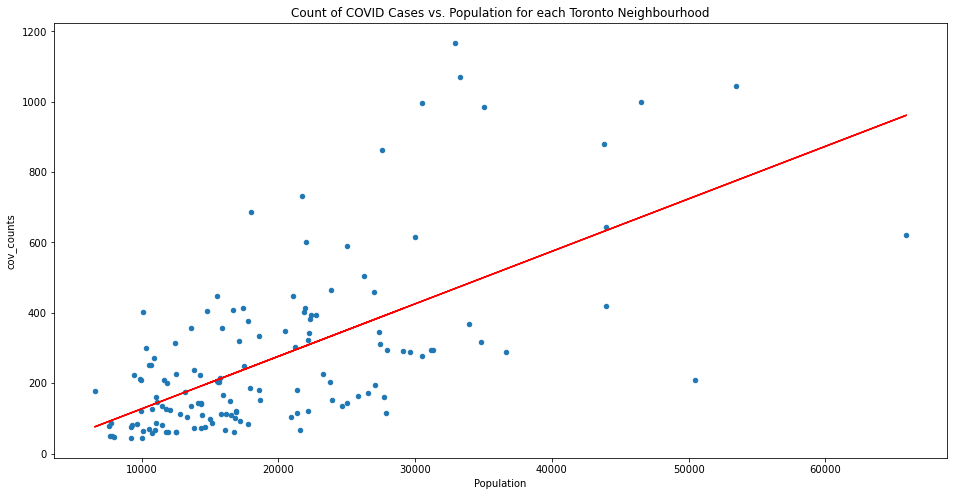

In [19]:
# plot each Neighborhood's COVID count against its population
fig, ax = plt.subplots(figsize=(16,8))
nbhd_cov.plot.scatter("Population", "cov_counts", ax=ax,
                      title='Count of COVID Cases vs. Population for each Toronto Neighbourhood');
# plot linear regression trend line
plt.plot(X_OLS1, nbhdpop_cov_LR.predict(X_OLS1), 'r-');